In [63]:
# Imports here
import pandas as pd
import numpy as np
import os

# Data filtering
import scipy.stats

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches

# Kmeans
import sklearn
from sklearn.cluster import KMeans

# Agglomerative
import seaborn as sns; sns.set(color_codes=True) 

# Spectral
from sklearn.cluster import SpectralClustering

# Cluster analysis
from sklearn import metrics

# Dimensionality Reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

%matplotlib inline

In [2]:
cohortDir = "/home/jenna/Research/data/Preadolescents/"

siteClasses = []
subjId = []
fd_dag = []
dvars_dag = []
cr = []
mi = []
# dice = []
fd_bold = []
dvars_bold = []

# Read features from .csv files

In [3]:
def readList(fn):
    data = pd.read_csv(fn, header=None)    
    return data.values.flatten().tolist()

In [4]:
def readTable(fn):
    data = pd.read_csv(fn, header=None)
    return data.values # returns a numpy array

In [5]:
def convertTableToList(tab):
    return tab.flatten().tolist()

In [6]:
def convertArrayToDataFrame(array, rowLabels):
    return pd.DataFrame(data=array,
                        index=rowLabels)

In [7]:
# Get sorted list of sites
sites = sorted([site.path for site in os.scandir(cohortDir) if site.is_dir()])
# for each site
for site in sites:
    # Get sorted list of subjects
    subjects = sorted([os.path.join(subj.path, "metrics") for subj in os.scandir(site) if os.path.exists(os.path.join(subj, 'metrics'))])
    print(site, len(subjects))
    siteClasses.extend(len(subjects)*[site.split("/")[-1]])
    # for subject in site
    for subject in subjects:
        subjId.append(subject.split("/")[-2])
        print(len(readList(os.path.join(subject, "corrected_dag-displacement-metrics.csv"))))
        # read in FD
        fd_dag.append(readList(os.path.join(subject, "corrected_dag-displacement-metrics.csv")))
        # read in DVARS
        dvars_dag.append(readList(os.path.join(subject, "corrected_dag-intensity-metrics.csv")))
        # read in correlation ratio matrix
#         cr.append(convertTableToList(readTable(os.path.join(subject, "dag-correlation-matrix.csv")))[:150])
        # read in mutual information matrix (calculated using fsl)
#         mi.append(convertTableToList(readTable(os.path.join(subject, "dag-fsl-mi-matrix.csv")))[:150])
        # read in FD
#         fd_bold.append(readList(os.path.join(subject, "BOLD-displacement-metrics.csv")))
        # read in DVARS
#         dvars_bold.append(readList(os.path.join(subject, "BOLD-intensity-metrics.csv")))
        

/home/jenna/Research/data/Preadolescents/BOSTON 19
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
/home/jenna/Research/data/Preadolescents/CCHMC 8
414
414
632
632
414
414
414
414
/home/jenna/Research/data/Preadolescents/CHLA 24
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
380
/home/jenna/Research/data/Preadolescents/CHOP 97
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
470
/home/jenna/Research/data/Preadolescents/COLUMBIA 6
470
470
470
470
470
470
/home/jenna/Research/data/Preadolescents/DUKE 10
150
150
150
150
150
150
150
150
150
150
/home/jenna/Research/data/Preadolescents/EMOR

# Calculate usability statistics

In [60]:
## Looking only at image volumes
# Total
print("Total image volumes:    ", len(np.asarray(fd_dag).flatten()))

# FD
count_fd = len([1 for i in np.asarray(fd_dag).flatten() if i > 0.2])
print("# volumes meeting FD:   ", count_fd)

# DVARS
count_dvars = len([1 for i in np.asarray(dvars_dag).flatten() if i > 25])
print("# volumes meeting DVARs:", count_dvars)

# Both
count_both = len([1 for i, j in zip(np.asarray(fd_dag).flatten(), np.asarray(dvars_dag).flatten()) if i > 0.2 and j > 25])
print("# volumes meeting both: ", count_both)

Total image volumes:     32850
# volumes meeting FD:    27686
# volumes meeting DVARs: 30416
# volumes meeting both:  27228


In [62]:
## Looking only at image volumes
# Total
print("Total image sequences:    ", len(np.asarray(fd_dag)))

#***TIPSY JENNA SAYS TO ADD CODE HERE FOR COMARING EACH SEQUENCE TO THE USABILITY CRITERIA
# FD
count_fd = len([1 for i in np.asarray(fd_dag) if i > 0.2])
print("# volumes meeting FD:   ", count_fd)

# DVARS
count_dvars = len([1 for i in np.asarray(dvars_dag).flatten() if i > 25])
print("# volumes meeting DVARs:", count_dvars)

# Both
count_both = len([1 for i, j in zip(np.asarray(fd_dag).flatten(), np.asarray(dvars_dag).flatten()) if i > 0.2 and j > 25])
print("# volumes meeting both: ", count_both)
#***THANKS HUN

Total image sequences:     219
# volumes meeting FD:    27686
# volumes meeting DVARs: 30416
# volumes meeting both:  27228


# Make class dictionaries

In [51]:
# Generate a dictionary for mapping sites to numbers
siteDict = {site:list(set(sorted(siteClasses))).index(site) for site in list(set(sorted(siteClasses)))}
print(siteDict)

{'DUKE': 0, 'CCHMC': 1, 'BOSTON': 2, 'MUSC': 3, 'UTAH': 4, 'CHOP': 5, 'CHLA': 6, 'COLUMBIA': 7, 'WISC': 8, 'EMORY': 9}


In [ ]:
# Generate a dictionary for mapping sites to scanner types to numbers
scannerDict = {
    'DUKE': 2, 
    'CCHMC': 3, 
    'BOSTON': 1, 
    'MUSC': 1, 
    'UTAH': 1, 
    'CHOP': 1, 
    'CHLA': 3, 
    'COLUMBIA': 1, 
    'WISC': 1, 
    'EMORY': 1,
    'PITT': 1,
    'MICH': 3
}
# 1 - Simens Multiband (Boston, CHoP, Emory, MUSC, New York, Pittsburgh, Utah, Wisconsin) - 470 volumes
# 3 - Philips Multiband (CHLA, CCHMC/Cincinnati, Michigan) - 380 volumes
# 2 - Siemens Single Band (Duke) - 150 volumes

# Data Preprocessing

In [9]:
# Get the first N elements in each list - accounting for different sequence lengths
N = np.min([len(subj) for subj in fd_dag])
print(N)

fd_dag = [subj[:N] for subj in fd_dag]
dvars_dag = [subj[:N] for subj in dvars_dag]

150


In [10]:
# Convert arrays to dataframes for cleaning
df_fd_dag = convertArrayToDataFrame(fd_dag, subjId)
df_dvars_dag = convertArrayToDataFrame(dvars_dag, subjId)
df_classes = convertArrayToDataFrame(siteClasses, subjId)

In [11]:
# Perform outlier detection: identify sequences where there is an outlier in any of the metrics. Don't use these sequences.
# Using the t-statistic: like a z-score, but only the sample mean and std. are known
# Except in python using scipy, it looks like the zscore is the way to go
# Note: outliers are specified as DAG registered sequences who have a zscore at any frame outside of 3 std above and below the mean

def identifyOutliers(dataDf):
    # Calculate the zscore for all of the columns
    zscores = (dataDf - dataDf.mean())/dataDf.std()
    zscores = zscores.fillna(0)
#     plt.hist(zscores.values.flatten())
    
    highMotionSubjects = []
    
    # For each row in the data frame of zscores
    for index, row in zscores.iterrows():
        # If the row contains a value > 3 or < -3 (value is over 3 standard deviations from the mean)
        if min(row) < -3 or max(row) > 3:
            # Add the label for that row to a list (print for now)
#             print(index)
            highMotionSubjects.append(index)
            
    return highMotionSubjects

In [12]:
highMotion = identifyOutliers(df_fd_dag)
highMotion.extend(identifyOutliers(df_dvars_dag))
highMotion = list(set(highMotion))
print("Number of high motion:",len(highMotion))
print("Total images:         ", df_fd_dag.shape[0])
print("Remaining images:     ", df_fd_dag.shape[0] - len(highMotion))

Number of high motion: 48
Total images:          219
Remaining images:      171


In [13]:
# Remove the high motion images from the data and the classes
df_fd_dag = df_fd_dag.drop(highMotion)
df_dvars_dag = df_dvars_dag.drop(highMotion)
df_classes = df_classes.drop(highMotion)

# Make figures (functions)

In [14]:
def viewDataList(y, yax="", title=""):
    fig = plt.figure()
    plt.plot(y)
    plt.xlabel("Image Volume Number")
    plt.ylabel(yax)
    plt.title(title)
    

In [15]:
def viewDataArray(data):
    sns.heatmap(data)

In [16]:
def performPCA(data):
    pca = PCA(n_components=2)
    components = pca.fit_transform(data)
    return components

In [17]:
def performTSNE(data):
    tsne = TSNE(n_components=2,
                init='random', 
                random_state=0)
    tsne_projected = tsne.fit_transform(data)
    return tsne_projected

In [18]:
def performUMAP(data):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(data)
    return embedding

In [19]:
def showClusterResults(features, classes, title=""):
    fig = plt.figure()
    plt.scatter(features[:, 0], features[:, 1], c=classes, cmap='viridis')
    plt.title(title)
    plt.show()

# Unsupervised ML Functions

In [20]:
def agglomerativeClustering(data, classes, sitesLookup):
    current_palette = sns.color_palette("bright")
    colors=[current_palette[sitesLookup[c]] for c in classes]
    legend = [mpatches.Patch(color=current_palette[sitesLookup[c]], label=c) for c in list(set(classes))]
    # sns.clustermap # https://seaborn.pydata.org/generated/seaborn.clustermap.html
    # cosine distance # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
    # linkage? # https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
    g = sns.clustermap(data,
                       col_cluster=False,
                       row_colors=colors,
                       cmap="jet") #, metric='cosine')
    
    l = g.ax_heatmap.legend(loc='upper right', handles=legend, frameon=True)
    l.set_title(title='Site Key')

In [21]:
def kmeansClustering(data, k):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    y_pred = kmeans.predict(data)
    # Need to analyze results: how many subjects from each class are in each cluster
    return y_pred, kmeans


In [22]:
def spectralClustering(data, k):
    spectral=SpectralClustering(n_clusters=k)
    y_pred = spectral.fit_predict(data)
    return y_pred

In [ ]:
# https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation
def analyzeClusteringResults(labels_actual, labels_predicted):
    # consensus measure: 1.0 is perfect match, close to 0.0 or negative is bad
    metrics.adjusted_rand_score(labels_actual, labels_predicted)
    # consensus measure: 1.0 is perfect match, independent labels have negative values
    metrics.adjusted_mutual_info_score(labels_actual, labels_predicted)
    # homogeneity = each cluster contains only members of a single class [0.0, 1.0]
    # symmetric, [0.0, 1.0]
    metrics.homogeneity_score(labels_actual, labels_predicted)
    # completeness = all members of a given class are assigned to the same cluster [0.0, 1.0]
    # symmetric, [0.0, 1.0]
    metrics.completeness_score(labels_actual, labels_predicted)
    # harmonic mean of homogeneity and completeness: 
    # beta = 1 for equal
    # beta > 1 for more weight on completeness
    # beta < 1 for more weight on homogeneity
    # symmetric, [0.0, 1.0]
    metrics.v_measure_score(labels_actual, labels_predicted)

In [ ]:
def analyzeClusteringModel(data, labels):
    # silhouette coefficient: measure of mean distance between sample and rest of its class and mean distance between sample and points in nearest cluster
    # range -1 for incorrect clustering to 1 for correct clustering
    # biased toward higher scores for convex clusters
    metrics.silhouette_score(data, labels)
    # calinski-harabasz index: within cluster dispersion vs. between-cluster dispersion
    # higher score means dense, well separated clusters
    metrics.calinski_harabasz_score(data, labels)
    # davies-bouldin index
    # lower index  = better separation between clusters
    # drawback: higher for convex clusters, low values not necessarily related to the best information retrieval
    metrics.davies_bouldin_score(data, labels)

# Supervised ML Functions

In [23]:
def regression():
    pass

In [24]:
def svm():
    pass

In [25]:
def generateNN(): # lstm neural network
    pass

# Sandbox

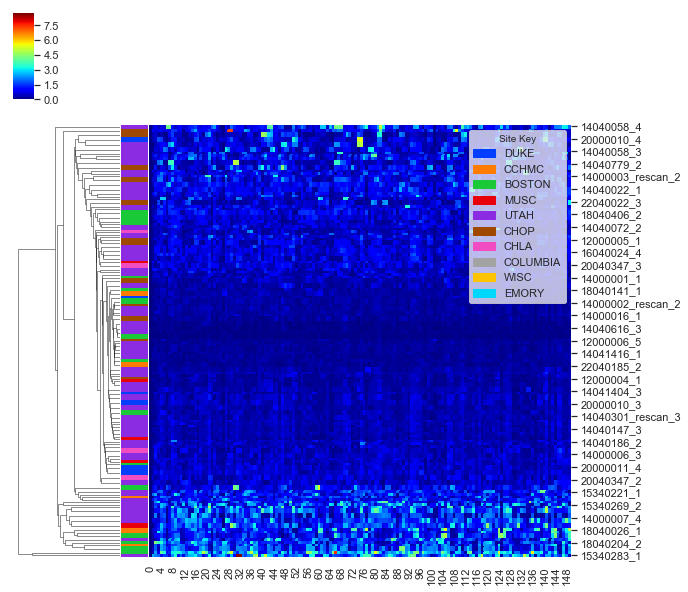

In [29]:
# Testing agglomerative clustering
agglomerativeClustering(df_fd_dag, siteClasses, siteDict)

In [45]:
# Testing k-means
y_kmeans = kmeansClustering(df_fd_dag.values, 5)
print(y_kmeans)

[1 1 1 1 4 4 1 1 4 4 4 1 1 1 1 4 4 4 4 4 4 4 4 0 2 1 0 4 4 2 2 4 4 1 1 2 2
 1 1 0 0 1 1 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 1 1 2 2 4 4 1 1
 1 1 3 3 1 1 1 4 4 4 1 1 2 4 4 4 4 1 4 2 2 4 4 4 4 4 4 4 4 4 4 1 1 1 1 4 4
 4 4 1 1 4 4 4 2 1 1 4 4 4 4 1 1 4 1 1 2 1 2 2 1 4 4 4 1 1 1 4 4 4 1 1 2 2
 2 2 4 1 4 4 4 4 4 4 1 1 4 4 4 4 4 4 4 4 4 1 1]


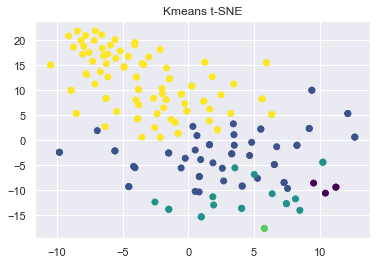

In [32]:
# Testing TSNE
tsne_features = performTSNE(df_fd_dag)
showClusterResults(tsne_features, y_kmeans, title="Kmeans t-SNE")

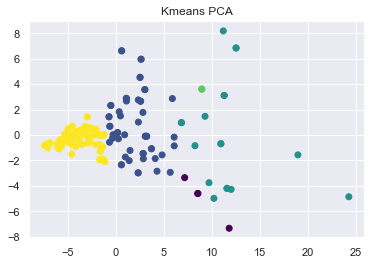

In [33]:
# Testing PCA
pca_features = performPCA(df_fd_dag)
showClusterResults(pca_features, y_kmeans, title='Kmeans PCA')

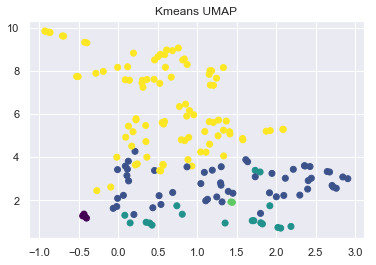

In [34]:
# Testing UMAP
umap_features = performUMAP(df_fd_dag)
showClusterResults(umap_features, y_kmeans, title='Kmeans UMAP')

In [47]:
# Testing k-means
y_spectral = spectralClustering(df_fd_dag, 6)
print(y_spectral)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/home/jenna/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  n_init=n_init)


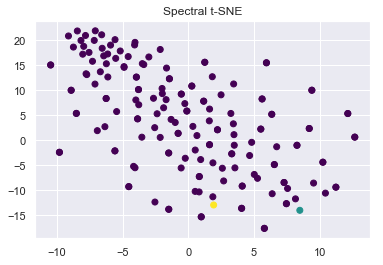

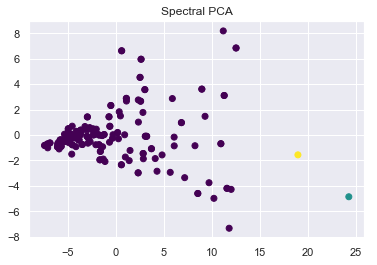

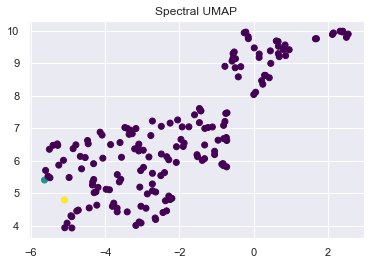

In [50]:
# Testing TSNE
tsne_features = performTSNE(df_fd_dag)
showClusterResults(tsne_features, y_spectral, title="Spectral t-SNE")

# Testing PCA
pca_features = performPCA(df_fd_dag)
showClusterResults(pca_features, y_spectral, title='Spectral PCA')

# Testing UMAP
umap_features = performUMAP(df_fd_dag)
showClusterResults(umap_features, y_spectral, title='Spectral UMAP')

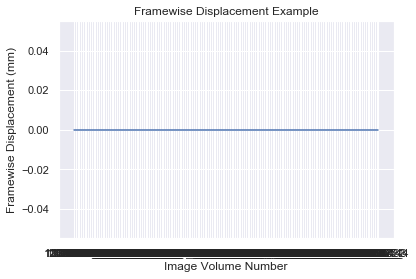

In [49]:
viewDataList(df_fd_dag[0], 
             yax="Framewise Displacement (mm)",
             title="Framewise Displacement Example")

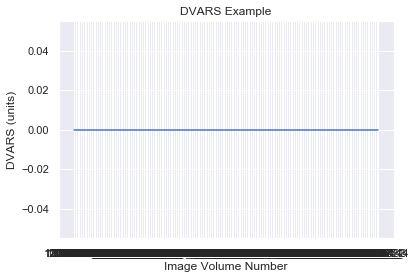

In [38]:
viewDataList(df_dvars_dag[0], 
             yax="DVARS (units)",
             title="DVARS Example")

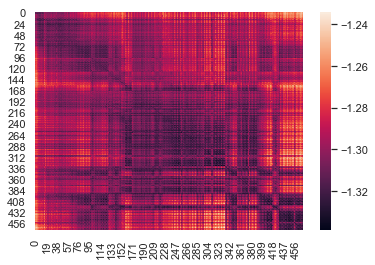

In [39]:
viewDataArray(readTable(os.path.join(subject, "dag-fsl-mi-matrix.csv")))

Text(0.5, 1.0, 'Voxel Signal')

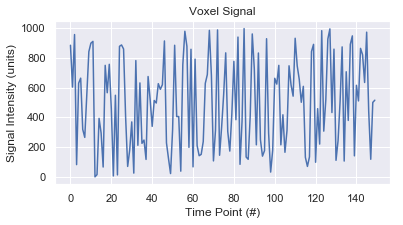

In [40]:
fig = plt.figure(figsize=(6,3))

plt.plot(np.random.randint(0, 1000, size=(150,)))
plt.xlabel("Time Point (#)")
plt.ylabel("Signal Intensity (units)")
plt.title("Voxel Signal")